# 🚀 Real Estate - advanced estimator

❗️ In the previous challenge, we saw that if we have more flats than features  in our dataset ($\large n$ observations $\large> p$ features), that's why we can't "solve" the equation $\large X\theta = Y$. And without a deterministic formula for $\large \theta$, we would no longer be able to predict the prices of new flats anymore...!

----

🎯 In this exercise, we have now access to a bigger dataset consisting of 1000 flats and we want to refine our prediction for the same new flat as before:

- `Surface`: 3000 $ft^2$
- `Bedrooms`: 5 
- `Floors`: 1

❌ Instead of solving $\large X\theta = Y$ with a matrix $\large X$ of shape $ (1000,4)$ that is **`non-invertible`**...

🚀 ...We will find $\large {\theta} = \begin{bmatrix}
     \theta_0 \\
     \theta_1 \\
    \theta_2 \\
     \theta_3
\end{bmatrix}_{4 \times 1}$ that minimizes the error $ \large e = X\hat{\theta} - Y $: this approach is called a **`Linear Regression model`**. We will measure this error $e$ using the Euclidian distance $\large \left\|e\right\|$ and the **`Mean Squared Error.`**

👉 Let's compute $\large \hat{\theta}$ to find an approximate estimation of the new flat's price.


In [260]:
# Import some "default" libraries
# You can now use Pandas to manipulate the Dataframe conveniently

""" Data manipulation"""
import numpy as np
import pandas as pd
import math

""" Data visualization"""
# import seaborn and pyplot(matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

## (1) Data Exploration

We load the dataset **flats.csv** below

In [198]:
df = pd.read_csv("flats.csv")
df

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
...,...,...,...,...
995,700.0,9,3680,2.0
996,272.0,3,1528,2.0
997,350.0,3,1050,1.0
998,649.0,4,2980,2.0


👀 Use `scatterplots` to  figure out visually <u><i>which feature gives the most information about prices:</i></u>

Text(0.5, 1.0, 'Price vs surface')

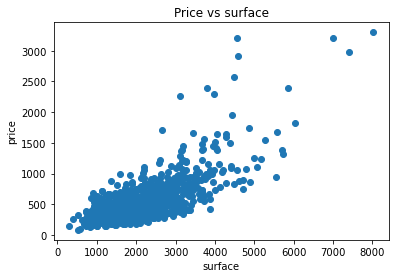

In [199]:
plot_surface = plt.scatter(df.surface, df.price)
plt.xlabel("surface")
plt.ylabel("price")
plt.title("Price vs surface")


Text(0.5, 1.0, 'Price vs floors')

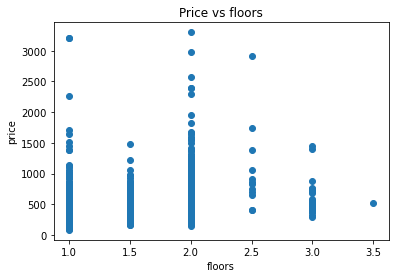

In [200]:
plt.scatter(df.floors, df.price)
plt.xlabel("floors")
plt.ylabel("price")
plt.title("Price vs floors")


Text(0.5, 1.0, 'Price vs bedrooms')

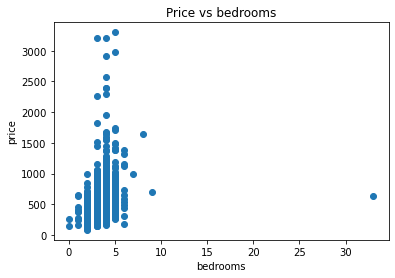

In [201]:
plt.scatter(df.bedrooms, df.price)
plt.xlabel("bedrooms")
plt.ylabel("price")
plt.title("Price vs bedrooms")


👉 It seems that `surface` is a stronger indicator of price than the number of bedrooms or floors. In statistics, we say that `price` is more **correlated** with `surface` than with other features. 

👉 Let's double-check this by running [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) below, which computes correlation coefficients between each pair of columns of the DataFrame. 

<i> <u>Remarkable values:</u></i>
* 1 means that the two columns  are perfectly  correlated 📈 
* -1 means that the two columns perfectly inversely correlated 📉 
* 0 means that the two columns not *linearly* correlated 😐
    
<details>
    <summary><i>Why do we use the correlation coefficient and not the covariance coefficient ?</i></summary>
    
✅ <u>Similitudes</u>:
    
* 📈 Positive correlations and positive covariances between two variables X and Y mean the same thing: When X increases, Y increases and vice-versa. When X decreases, Y decreases and vice-versa.
    
* 📉 Negative correlations and negative covariances between two variables X and Y mean the same thing: When X increases, Y decreases and vice-versa. When X decreases, Y increases and vice-versa
    
* 🤔 A null correlation and a null covariance between two variables X and Y mean the same thing: 
    * They are _not linearly correlated_ in a sense that there would exists two real numbers $a$ and $b$  such that $ Y = aX + b$ 
    * However, they can still have another type of relation such as $Y = X^{2}$ (quadratic relation), $Y = e^{X}$ (exponential relation), $Y = ln(X)$ (logarithmic relation), $Y = sin(\sqrt{1+X^7})$ (super weird relation), ...
    
❗️ <u>Main difference</u>:
    
* 😖 The covariance between two variables X and Y can be infinitely big positively or negatively : $ cov(X,Y) \in ( - \infty ; + \infty ) $
    
    * _Example_: if $ cov (X,Y) = 10 $ and $ cov (X,Z) = 30 $, can you say that X and Z are "more correlated" ? ❌_Hell No !_ 
    * You cannot compare apples, oranges and bananas. 

* 🧑🏻‍🏫 How to solve this problem ?
    * Consider the correlation instead, often denoted by the Greek Letter $\rho$ (pronounce `"rhô"`)
    
👉<u>Consequence</u>:
  
* You can view the correlation as a _standardized covariance_, we simply divide the covariance by both the standard deviation of $X$ and the standard deviation of $Y$    
$$ \large  \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \in [0;1]$$
    
    *  _Let's continue our example_: suppose now that $ \rho(X,Y) = 0.80 $ and $ \rho(X,Z) = 0.15 $, would you still want to say that X and Z are more correlated ? No. Actually, X and Y are more correlated than X and Z !
</details>

In [202]:
corr = df.corr()
corr


,price,bedrooms,surface,floors
price,1.000000,0.239623,0.732790,0.258263
bedrooms,0.239623,1.000000,0.417170,0.131993
surface,0.732790,0.417170,1.000000,0.357512
floors,0.258263,0.131993,0.357512,1.000000


🎨 For a quicker glimpse of this matrix, you can use a **heatmap** from [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

<details>
    <summary><i>Additional tips to display a nicer correlation matrix</i></summary>

* **`cmap`**: *Seaborn* being a visualisation library built on top of *Matpotlib*, you can use the argument [*cmap*](https://matplotlib.org/stable/tutorials/colors/colormaps.html) which stands for _color map_ to use 

* **`annot`** : To read the correlations even faster, you can show the correlation coefficients directly on the colored heatmap
   
* **`annot_kws`** : You can customize how the correlation coefficients appear
</details>

<AxesSubplot:>

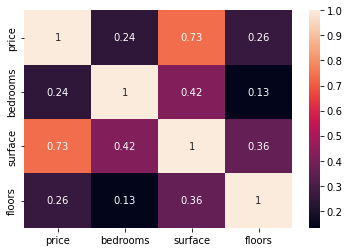

In [203]:
sns.heatmap(corr, annot=True)

## (2) Estimator with 1 feature

Let's try to build a statistical estimator of **price**  as a function of  only one feature, the **surface**.

🎯 Let's try to fit a **linear regression** between the two variables.

Practically speaking, we want to choose the best parameters $\hat{\theta}$ = (`slope`, `intercept`) such that the `predicted price = slope * surface + intercept` is as close as possible to the `price` in terms of Mean Squared Errors.

📅 During the next weeks, we will discover and study different models (Linear Regression, KNN, Logistic Regression, Neural Networks, etc.). 

👉 An important part of your job is to choose the right model and optimizing the parameters to make the best predictions.

### (2.1) Visual approach

❓ Implement the function `plot_line(slope, intercept, ax)` 
* This function plots a line with the `slope` and `intercept` arguments on the `ax` figure. We added the argument ax, so that you can plot the line(s) on your scatterplot.
* When you are done with coding the function, play with different values of `(slope, intercept)` until you find a “good linear approximation” of the data. Can you find the best fit ?

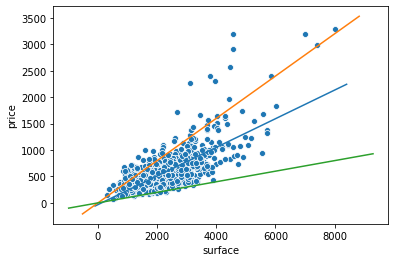

In [204]:
def plot_line(slope, intercept, ax):
    """Plot a line from slope and intercept on the ax"""
    price = slope * ax + intercept
    plt.plot(ax, price)


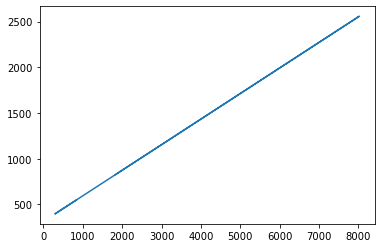

In [205]:
# TO DO: play with slopes and intercepts to get the best fit
initial_slope = 0.3
initial_intercept = 100
plot_line(slope, intercept, df.surface)


😅 Not so easy (and not very “scientific”), right?

### (2.2) Computational approach

🔥 To make sure that our estimator line is the best possible one, we need to compute  the **Mean Squared Error** between the **real prices** and the **predicted prices**!

👉 Remember that :

* For each appartment, `predicted_price = slope * surface + intercept`
* Both the **vector of real prices** and the **vector of predicted prices** are of shape $ (1000,1)$

#### (2.2.1) Squared Errors

<u><b>Step 1</b></u>

❓For each row (_i.e. flat_), we should evaluate the `squared_error = (price - predicted_price)**2` ❓

In [206]:
def squared_errors(slope, intercept, surfaces, prices):
    """TO DO: return an array containing the squared errors between
    all real prices from the dataset and the predicted prices
    """
    sqr_array = np.array([])
    for surface in surfaces:
        predicted_price = slope * surface + intercept

    for price in prices:
        squared_error = (price - predicted_price) ** 2
        sqr_array = np.append(sqr_array, squared_error)

    return sqr_array

In [207]:
price_squered_error = squared_errors(
    initial_slope, initial_intercept, df.surface, df.price
)
price_squered_error

array([5.62500000e+03, 2.28010000e+04, 8.41000000e+02, 9.31225000e+03,
       8.32322500e+04, 1.23210000e+04, 8.10000000e+03, 3.61201000e+05,
       4.04010000e+04, 6.97225000e+03, 3.49690000e+04, 4.18611600e+06,
       1.29600000e+03, 1.41610000e+04, 9.98560000e+04, 3.96900000e+03,
       2.94122500e+04, 3.61000000e+02, 9.21600000e+03, 4.38902500e+04,
       5.05521000e+05, 2.40100000e+03, 2.27708100e+04, 5.34361000e+03,
       8.83600000e+05, 6.81210000e+04, 1.37641000e+05, 8.29440000e+04,
       6.76000000e+02, 3.62902500e+02, 1.34560000e+04, 4.48900000e+03,
       1.71610000e+04, 2.68960000e+04, 6.55360000e+04, 7.39600000e+03,
       2.24613166e+04, 4.76790250e+03, 1.41610000e+04, 1.29600000e+03,
       3.29820490e+03, 2.17562500e+02, 1.08900000e+03, 9.05709025e+04,
       1.52881000e+05, 4.44999025e+04, 3.48690250e+03, 2.32806250e+05,
       3.84400000e+03, 2.05779025e+04, 5.71210000e+04, 1.08160000e+04,
       2.59590250e+03, 1.29600000e+03, 8.12820100e+06, 1.85717903e+05,
      

💡 A general principle in Data Science / Modelling is that $ \large error = f(y, \hat{y})$ where:

* $ \large y$ is the real value
* $ \large \hat{y} $ the predicted valute
* $ \large f$ is often called a **Loss Function** or a **Cost Function** 
 

#### (2.2.2) Mean Squared Errors (MSE)

<u><b>Step 2</b></u>

❓ Create the `mse` function which should return the mean of the array returned by the `squared_errors` function. ❓

In [208]:
def mse(slope, intercept, surfaces, prices):
    """TO DO: Return the mean of the array contained in squared_errors as a float."""
    sqr_array = np.array([])
    for surface in surfaces:
        predicted_price = slope * surface + intercept

    for price in prices:
        squared_error = (price - predicted_price) ** 2
        sqr_array = np.append(sqr_array, squared_error)

    mean = sqr_array.mean()
    return mean

👉 In section _(2.1) Visual approach_, you visually tried to estimate the "best line", which consists in finding the best pair `(slope, intercept)`. 

❓Using this "best pair", compute the MSE of your estimator. ❓

In [226]:
initial_slope = 0.3
initial_intercept = 100
best_pair = mse(initial_slope, initial_intercept, df.surface, df.price)
best_pair
print(
    "With slope = {} and intercept = {} the MSE = {}.".format(
        initial_slope, initial_intercept, best_pair
    )
)

With slope = 0.3 and intercept = 100 the MSE = 165638.141642907.


### (2.3) Finding the best parameters

👉 Keep playing with different values for `slope` and `intercept` and try to get the best fit by hand!  Notice how hard it is to optimize both parameters at the same time.


👇 Follow the steps down below to get an idea of one potential approach:

#### (2.3.1) Finding the `best slope`

<b><i><u> Step 1 :</u></i></b>

Start by fixing an  `initial_intercept` with your best estimate, then find a slope which approximately minimizes the function  `mse=f(slope)`

In [210]:
# Define an initial_intercept, for instance, we may suppose there is always a small transaction fee even for very small flats?
initial_intercept = 100


In [227]:
# Create a range of 100 slopes which contains what you believe is the optimal slope (hint: np.linspace())
slope_range = np.linspace(
    0.2, 0.8, num=100 + 1, endpoint=True, retstep=False, dtype=None, axis=0
)
slope_range

array([0.2  , 0.206, 0.212, 0.218, 0.224, 0.23 , 0.236, 0.242, 0.248,
       0.254, 0.26 , 0.266, 0.272, 0.278, 0.284, 0.29 , 0.296, 0.302,
       0.308, 0.314, 0.32 , 0.326, 0.332, 0.338, 0.344, 0.35 , 0.356,
       0.362, 0.368, 0.374, 0.38 , 0.386, 0.392, 0.398, 0.404, 0.41 ,
       0.416, 0.422, 0.428, 0.434, 0.44 , 0.446, 0.452, 0.458, 0.464,
       0.47 , 0.476, 0.482, 0.488, 0.494, 0.5  , 0.506, 0.512, 0.518,
       0.524, 0.53 , 0.536, 0.542, 0.548, 0.554, 0.56 , 0.566, 0.572,
       0.578, 0.584, 0.59 , 0.596, 0.602, 0.608, 0.614, 0.62 , 0.626,
       0.632, 0.638, 0.644, 0.65 , 0.656, 0.662, 0.668, 0.674, 0.68 ,
       0.686, 0.692, 0.698, 0.704, 0.71 , 0.716, 0.722, 0.728, 0.734,
       0.74 , 0.746, 0.752, 0.758, 0.764, 0.77 , 0.776, 0.782, 0.788,
       0.794, 0.8  ])

In [228]:
# Create the list of MSEs for each slope value
mses_slopes = []
for slope in slope_range:
    mean = mse(slope, initial_intercept, df.surface, df.price)
    mses_slopes.append(mean)

mses_slopes

[205418.849264907,
 202643.46720758697,
 199917.68595026695,
 197241.50549294695,
 194614.92583562696,
 192037.946978307,
 189510.56892098702,
 187032.79166366695,
 184604.615206347,
 182226.039549027,
 179897.06469170703,
 177617.69063438702,
 175387.91737706703,
 173207.744919747,
 171077.17326242698,
 168996.202405107,
 166964.83234778696,
 164983.06309046698,
 163050.894633147,
 161168.326975827,
 159335.36011850697,
 157551.99406118697,
 155818.22880386698,
 154134.064346547,
 152499.500689227,
 150914.53783190702,
 149379.17577458697,
 147893.414517267,
 146457.25405994698,
 145070.69440262698,
 143733.73554530702,
 142446.377487987,
 141208.620230667,
 140020.463773347,
 138881.90811602699,
 137792.95325870698,
 136753.599201387,
 135763.845944067,
 134823.69348674698,
 133933.14182942698,
 133092.190972107,
 132300.840914787,
 131559.09165746698,
 130866.94320014698,
 130224.39554282698,
 129631.448685507,
 129088.102628187,
 128594.35737086702,
 128150.212913547,
 127755.66925

❓ Plot MSEs vs. slopes. Do you see a minimum ❓

🙃 If not, try another range of slopes!

Text(0.5, 0, 'slopes')

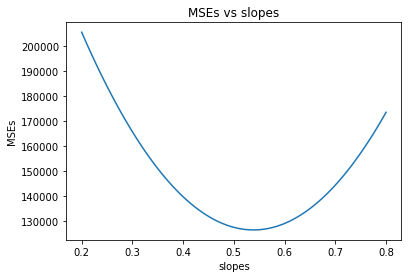

In [229]:
plt.plot(slope_range, mses_slopes)
plt.title("MSEs vs slopes")
plt.ylabel("MSEs")
plt.xlabel("slopes")

# ❓ Compute the minimum value of MSE for your `initial_intercept`, and the corresponding `slope_best` value ❓
<br>
<details>
    <summary><i>Hint</i></summary>
    
Here you can use Python's built-in `.min()` function, as well as `List.index()` method
    
</details>

In [230]:
MES_min = min(mses_slopes)
slope_best = slope_range[mses_slopes.index(min(mses_slopes))]
print(
    "The minimun value of MSE for best slope ({}) and initial_intercept ({}) equal to {}".format(
        slope_best, initial_intercept, MSE_min
    )
)

The minimun value of MSE for best slope (0.536) and initial_intercept (100) equal to 172581.33391969957


#### (2.3.2) Finding the `best intercept`

<b><i><u> Step 2 :</u></i></b>

🔨 Let's now fix the slope to that `slope_best` value, then re-use the previous approach to find "the" `intercept_best`.

In [231]:
# Create a range of 100 intercepts which contains what you believe is the optimal intercept
intercept_range = np.linspace(
    50, 150, num=100 + 1, endpoint=True, retstep=False, dtype=None, axis=0
)

In [232]:
# Create the list of MSEs for each intercept value
mses_intercept = []
for intercept in intercept_range:
    mean = mse(slope_best, intercept, df.surface, df.price)
    mses_intercept.append(mean)
mses_intercept


[129108.96775498697,
 129005.442120987,
 128903.91648698699,
 128804.390852987,
 128706.86521898699,
 128611.33958498698,
 128517.81395098698,
 128426.28831698697,
 128336.76268298698,
 128249.23704898698,
 128163.71141498699,
 128080.185780987,
 127998.660146987,
 127919.13451298699,
 127841.608878987,
 127766.08324498699,
 127692.55761098699,
 127621.031976987,
 127551.506342987,
 127483.980708987,
 127418.455074987,
 127354.92944098699,
 127293.403806987,
 127233.87817298698,
 127176.35253898699,
 127120.826904987,
 127067.301270987,
 127015.775636987,
 126966.250002987,
 126918.724368987,
 126873.198734987,
 126829.67310098698,
 126788.14746698698,
 126748.62183298697,
 126711.09619898701,
 126675.570564987,
 126642.044930987,
 126610.51929698698,
 126580.993662987,
 126553.468028987,
 126527.942394987,
 126504.41676098699,
 126482.89112698699,
 126463.36549298701,
 126445.83985898699,
 126430.31422498699,
 126416.788590987,
 126405.26295698699,
 126395.73732298698,
 126388.2116889

Text(0.5, 0, 'intercepts')

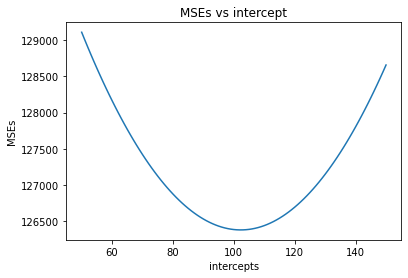

In [233]:
# Plot MSEs against intercept. Do you see a minimum? If not, try another range of intercept!
plt.plot(intercept_range, mses_intercept)
plt.title("MSEs vs intercept")
plt.ylabel("MSEs")
plt.xlabel("intercepts")

❓ Compute `mse_min`, the minimum value of MSEs when slope is equal to `slope_best` best, and store the corresponding best intercept as `intercept_best` ❓


In [236]:
mse_min = min(mses_intercept)
intercept_best = intercept_range[mses_intercept.index(min(mses_intercept))]
print(
    "The minimun value of MSE for best slope ({}) and best intercept ({}) equal to {}".format(
        slope_best, intercept_best, mse_min
    )
)

The minimun value of MSE for best slope (0.536) and best intercept (102.0) equal to 126377.634786987


🎉 **Great job**! By adding a non-zero intercept parameter, we have been able to reduce the MSE even more (Feel free to plot the regression line in your scatter plot to  confirm "visually" the approximate fit).

❓ However, what guarantees that these (`intercept_best`, `slope_best`) parameters are really the best ones? 

Text(0.5, 1.0, 'price vs surface and regression line')

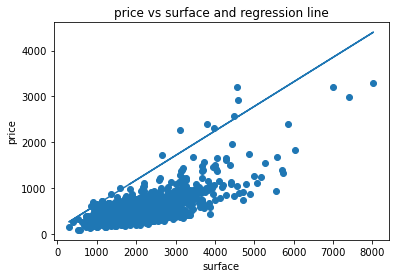

In [238]:
plot_surface = plt.scatter(df.surface, df.price)
plt.xlabel("surface")
plt.ylabel("price")
plot_line(slope_best, intercept_best, df.surface)
plt.title("price vs surface and regression line")

<details>
    <summary><i>👀 Explanations</i></summary>
    
We could maybe find an even better slope value by repeating step ①, this time fixing intercept at `intercept_best`! And then repeat step ② with the new slope to adjust the intercept again...
    
In order to find the global minimum of a 2-parameter function RMSE = f(slope, intercept), we may have to repeat step ① and ② indefinitely until values converge towards absolute minimums - and with no guarantee of success.
    
<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/decision-science/real-estate-minimizer.png'>
    
💪 You've just discovered one of the most fundamental aspects of machine learning: **iterative process for finding mimina**.  

👉 As you can guess, in the Data Scientist world, algorithms have been developed to automate and optimize such processes. In the next few weeks, you will discover the power of other algorithms such as **Gradient Descent**, and Python libaries such as `Stastmodels` that perform this iterative process for you. 

</details>



👉 Run the cells below if you are curious and want to find the real best slope and intercept for this dataset, computed using **Gradient Descent** 

<AxesSubplot:xlabel='surface', ylabel='price'>

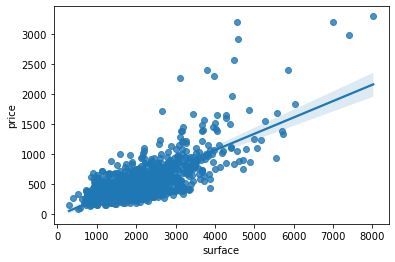

In [221]:
# plot the regression with seaborn
sns.regplot(x=df.surface, y=df.price)


In [222]:
# do a regression ols using statsmodels, exact solution)!
x = df.surface
y = df.price
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              6246.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):                        0.00
Time:                        20:35:43   Log-Likelihood:                         -6909.0
No. Observations:                1000   AIC:                                  1.382e+04
Df Residuals:                     999   BIC:                                  1.382e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
surface        0.2606      0.003     79.035      0.000       0.254       0.267
==============================================================================
Omnibus:                      569.903   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7810.452
Skew:                           2.325   Prob(JB):                         0.00
Kurtosis:                      15.877   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

❓ Let's go back to our initial question: What is your new prediction for the 5th flat below? How does it compare with your initial prediction based only on 4 flats? 

- `surface`: 3000 $ft^2$
- `bedrooms`: 5 
- `floors`: 1

In [259]:
# compute predicted price (Remember that the real price is 750,000$)
price = slope_best * 3000 + intercept_best
print("The predicted price for the new flat is {}K".format(price))

The predicted price for the new flat is 1710.0K


☝️ It's better than our initial deterministic estimator based on only 4 flats, but obviously we are missing the information provided by the number of bedrooms and floors in this prediction!

## (3) Estimator with _all features_ (surface, bedrooms, floors)?

💡 A linear regression with three features (**Multivariate Linear Regression**) works the same way as with one feature, but instead of determining only 2 parameters to minimize RMSE (`intercept` and `slope`), we will need to find 4 parameters: $\hat{\theta}$ = (`intercept`, `slope_surface`, `slope_bedrooms`, `slope_floors`). 

----

🗓 There will be a lecture fully dedicated to **Multivariate Linear Regression**

----

🗓 The same **Gradient Descent** iterative method is applicable, and you will code it yourself by hand later during the training session.

👉 Meanwhile, feel free to run the cell below to see the final result of this multivariate regression:

In [274]:
# Find the four regression coefficients with statsmodels
# method one
x = df[["surface", "bedrooms", "floors"]]
x = sm.add_constant(x)
y = df.price
model = sm.OLS(y, x)
result_1 = model.fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     393.4
Date:                Tue, 08 Nov 2022   Prob (F-statistic):          1.74e-168
Time:                        21:30:22   Log-Likelihood:                -6901.7
No. Observations:                1000   AIC:                         1.381e+04
Df Residuals:                     996   BIC:                         1.383e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1549     28.400      0.639      0.523     -37.576      73.886
surface        0.2870      0.009     30.682      0.000       0.269       0.305
bedrooms     -21.6236      6.367     -3.396      0.001     -34.119      -9.129
floors        -3.8119     14.989     -0.254      0.799     -33.225      25.602
==============================================================================
Omnibus:                      519.986   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6113.074
Skew:                           2.107   Prob(JB):                         0.00
Kurtosis:                      14.356   Cond. No.                     9.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [270]:
# method two
model = smf.ols(formula="price ~ surface + bedrooms + floors", data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     393.4
Date:                Tue, 08 Nov 2022   Prob (F-statistic):          1.74e-168
Time:                        21:27:40   Log-Likelihood:                -6901.7
No. Observations:                1000   AIC:                         1.381e+04
Df Residuals:                     996   BIC:                         1.383e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.1549     28.400      0.639      0.523     -37.576      73.886
surface        0.2870      0.009     30.682      0.000       0.269       0.305
bedrooms     -21.6236      6.367     -3.396      0.001     -34.119      -9.129
floors        -3.8119     14.989     -0.254      0.799     -33.225      25.602
==============================================================================
Omnibus:                      519.986   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6113.074
Skew:                           2.107   Prob(JB):                         0.00
Kurtosis:                      14.356   Cond. No.                     9.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [271]:
result.params


Intercept    18.154854
surface       0.286953
bedrooms    -21.623564
floors       -3.811868
dtype: float64

🎉 Now that we have found the best parameters $\theta = \begin{bmatrix}
     \theta_0 \\
     \theta_1 \\
    \theta_2 \\
     \theta_3 \\
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
     \theta_{intercept} \\
     \theta_{surface}\\
    \theta_{bedrooms} \\
     \theta_{floors}
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
    18.154854 \\
    0.286953 \\
    -21.623564 \\
    -3.811868
\end{bmatrix}_{4 \times 1}
$, 

we can predict the price of the new flat with:
* $3000 ft^2$
* $5$ bedrooms
* located on the $1st$ floor

$$ \hat{y_5} = \theta_0 + \theta_1 \times 3000 + \theta_2 \times 5 + \theta_3 \times 1 $$

In [272]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
price = 18.154854 + 0.286953 * 3000 + -21.623564 * 5 + -3.811868 * 1
print("The predicted price for the new flat is {}K".format(round(price, 2)))

The predicted price for the new flat is 767.08K


## (4) Concluding remarks on Linear Algebra 🧠

This **optimisation problem** can be summarized as follows

- We need to find a vector of parameters $\hat{\theta} = \begin{bmatrix}
     \theta_{intercept} \\
     \theta_{surface}\\
    \theta_{bedrooms} \\
     \theta_{floors}
\end{bmatrix}_{4 \times 1}$ 

- That minimizes an error $e = \left\|X\hat{\theta} - Y \right\|^2$

- For a given matrix of features $X$ [constant, surfaces, floors, bedrooms]  $\begin{bmatrix}
    1 & 620 & 1 & 1 \\
    1 & 3280 & 4 & 2 \\
    ... \\
    1 & 1900 & 2 & 2 \\
    1 & 1320 & 3 & 3
   \end{bmatrix}_{n \times 4}
$

- and a vector of observations $Y = \begin{bmatrix}
           y_{1} \\
           y_{2} \\
           \vdots \\
           y_{1000}
         \end{bmatrix}$ (prices)

Such minimum $\large \hat{\theta}$ is reached when the "derivatives" of $e$, that is $ \large 2 X^T(X\hat{\theta}−Y)$ equals zero (👉proof during the Regression Module). 
    
In other words, we need to solve the linear system $\large (X^T X)\hat{\theta}=X^TY$. 
    
This linear has a unique solution provided that no column of X can be expressed as a linear combination of the others: in that case $ \large (X^TX)^{-1}$ is invertible and the minimum is reached when $\large \hat{\theta} = (X^TX)^{-1} X^T Y$. Notice how X does not need to be squared anymore compared to the first challenge 💪.

💥 However, keep in mind that ***inverting matrices is computationally complex***. That is why other methods have been developed to find the minimum of a function, such as ***gradient descent***.
    
📚 Read more on [Stats.StackExchange](https://stats.stackexchange.com/a/278779) if you are interested!
</details>


🏁 Congratulations! 

💾 Don't forget to `save` your notebook!